In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('d:data/startup/master_readmission_dataset.csv')

print(df.shape)
df.head()

(101766, 54)


C:\Users\syeds\AppData\Local\Temp\ipykernel_23712\1776203474.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('d:data/startup/master_readmission_dataset.csv')


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,readmit_30,discharge_disposition,admission_type,admission_source
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,NO,0,Not Mapped,Unknown,Physician Referral
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,No,No,Ch,Yes,>30,0,Discharged to home,Emergency,Emergency Room
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,Yes,NO,0,Discharged to home,Emergency,Emergency Room
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,No,No,Ch,Yes,NO,0,Discharged to home,Emergency,Emergency Room
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,No,No,Ch,Yes,NO,0,Discharged to home,Emergency,Emergency Room


# Overall 30 day readmission rate

rate = 0.11159915885462728


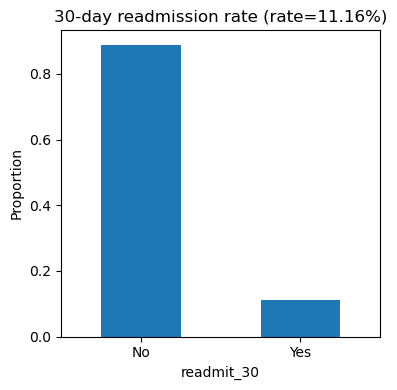

In [19]:
#readmit_30 tp 0/1
df["readmit_30"] = pd.to_numeric(df["readmit_30"], errors="coerce")

rate = df["readmit_30"].mean()
print("rate =", rate)

plt.figure(figsize=(4,4))
df["readmit_30"].value_counts(normalize=True).sort_index().plot(kind="bar")
plt.title(f"30-day readmission rate (rate={rate:.2%})")
plt.ylabel("Proportion")
plt.xticks([0,1], ["No", "Yes"], rotation=0)
plt.tight_layout()
plt.show()


“30-day readmission rate is ~11%, indicating class imbalance; accuracy alone will be misleading, so recall/ROC-AUC/PR-AUC will be emphasized.”

# Readmission by Age

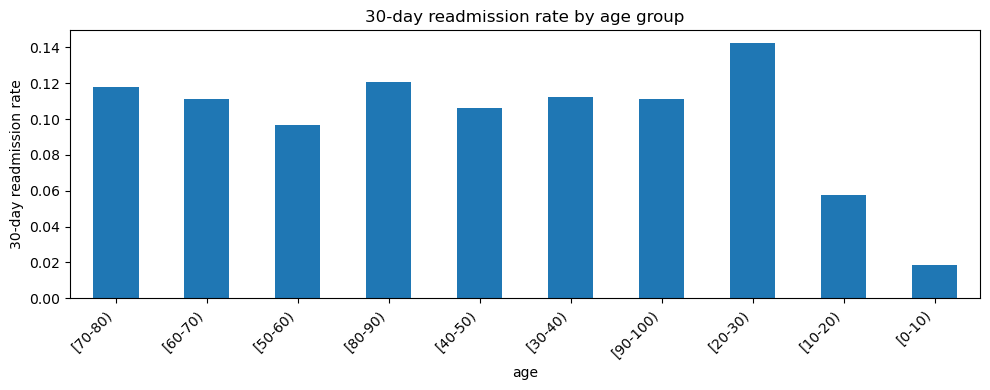

In [30]:
age_rate = df.groupby("age")["readmit_30"].mean()
age_count = df["age"].value_counts()

age_order = age_count.index.to_list()
age_rate = age_rate.reindex(age_order)

plt.figure(figsize=(10,4))
age_rate.plot(kind ="bar")
plt.ylabel("30-day readmission rate")
plt.title("30-day readmission rate by age group")
plt.xticks(rotation =45, ha = 'right')
plt.tight_layout()
plt.show()

Readmission risk varies by age group, Highest rate appears in (20–30) but with low volume older groups (70–90)) show consistently elevated readmission with high volume, making them more actionable.

Age is retained as a core feature for risk stratification.

# Readmission rate by Gender

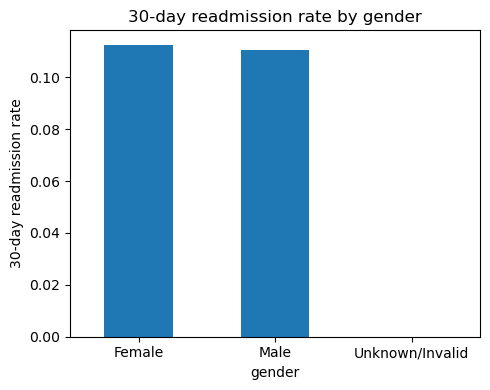

Counts:
 gender
Female             54708
Male               47055
Unknown/Invalid        3
Name: count, dtype: int64

Rates:
 gender
Female             0.112452
Male               0.110615
Unknown/Invalid    0.000000
Name: readmit_30, dtype: float64


In [38]:
g_rate = df.groupby("gender")["readmit_30"].mean().sort_values(ascending = False)
g_count = df["gender"].value_counts()

plt.figure(figsize=(5,4))
g_rate.plot(kind ="bar")
plt.ylabel("30-day readmission rate")
plt.title("30-day readmission rate by gender")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print("Counts:\n", g_count)
print("\nRates:\n", g_rate)

Female: 11.245%

Male: 11.062%

Difference is tiny → gender isn’t a major driver here (good to note).

Unknown/Invalid is only 3 rows → ignore or filter.

Readmission rates are similar across gender; gender likely contributes limited predictive value compared to clinical/utilization features.


# Readmission Rate by Race

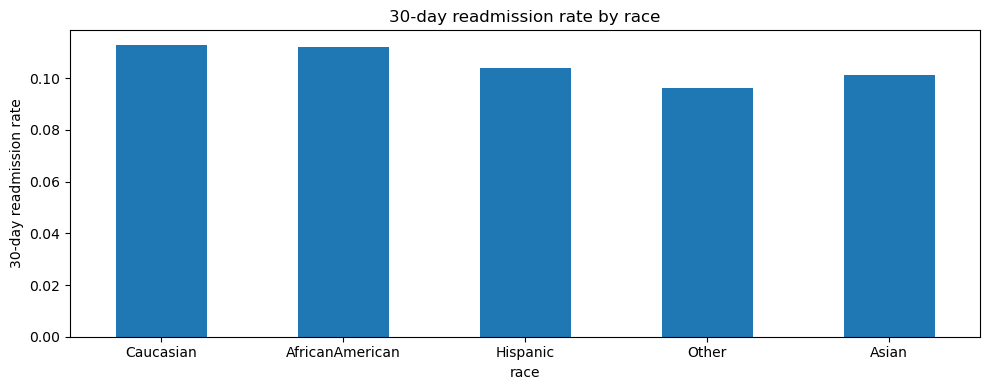

race
Caucasian          76099
AfricanAmerican    19210
Hispanic            2037
Other               1506
Asian                641
Name: count, dtype: int64
race
Caucasian          0.112906
AfricanAmerican    0.112181
Hispanic           0.104075
Other              0.096282
Asian              0.101404
Name: readmit_30, dtype: float64


In [47]:
race_rate = df.groupby("race")["readmit_30"].mean()
race_count = df["race"].value_counts()

race_rate = race_rate.reindex(race_count.index) #by volume

plt.figure(figsize=(10,4))
race_rate.plot(kind = "bar")
plt.ylabel("30-day readmission rate")
plt.title("30-day readmission rate by race")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print(race_count)
print(race_rate)

Rates are very similar across the two largest groups:

Caucasian: 11.29%

AfricanAmerican: 11.22%

Smaller groups show slightly lower rates, but their sample sizes are much smaller, so differences are less reliable.

Important framing: “This is descriptive; not causal. Used for monitoring and transparency.”

Race is not a huge driver here compared to operational/utilization features.

# Readmission rate by LOS(Length of Stay)

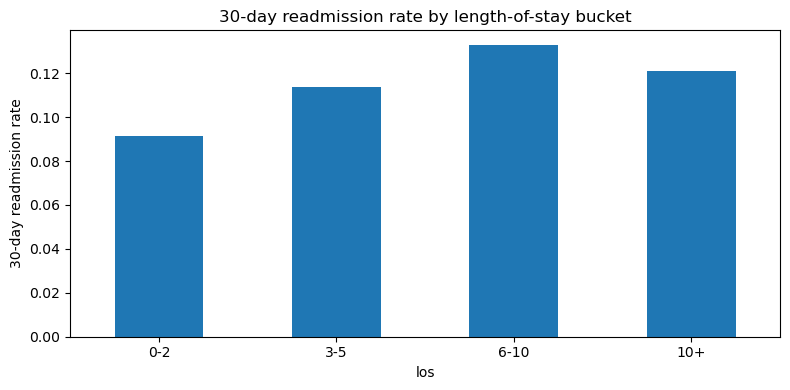

Counts:
 los
0-2     31432
3-5     41646
6-10    23133
10+      5555
Name: count, dtype: int64

Rates:
 los
0-2     0.091435
3-5     0.113744
6-10    0.132884
10+     0.120972
Name: readmit_30, dtype: float64


In [54]:
df["los"] = pd.cut(
    df["time_in_hospital"],
    bins= [0,2,5,10,100],
    labels = ["0-2", "3-5", "6-10","10+"],
    include_lowest = True
)

los_rate = df.groupby("los")["readmit_30"].mean().reindex(["0-2", "3-5", "6-10","10+"])
los_counts = df["los"].value_counts().reindex(["0-2", "3-5", "6-10","10+"])
                                                           
plt.figure(figsize=(8,4))
los_rate.plot(kind="bar")
plt.ylabel("30-day readmission rate")
plt.title("30-day readmission rate by length-of-stay bucket")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print("Counts:\n", los_counts)
print("\nRates:\n", los_rate)                                                          

Readmission risk increases with longer stays:

0–2 days: 9.14%

3–5 days: 11.37%

6–10 days: 13.29% (highest)

10+ days: 12.10% (still high, but fewer cases)

LOS is a strong proxy for case complexity → good predictive feature + actionable discharge planning signal.

# Readmission Rate by Admission Type

In [71]:
df["admission_type"].value_counts()

admission_type
Emergency        53990
Elective         18869
Urgent           18480
Unknown           5291
Not Available     4785
Not Mapped         320
Trauma Center       21
Newborn             10
Name: count, dtype: int64

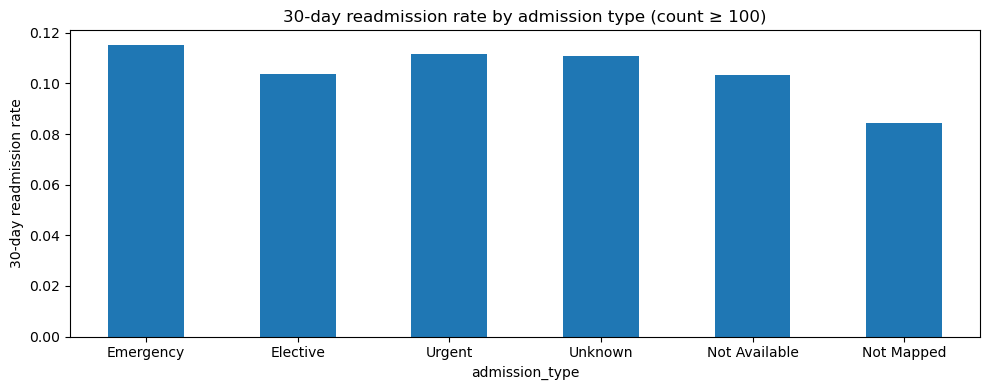

Kept categories:
 admission_type
Emergency        53990
Elective         18869
Urgent           18480
Unknown           5291
Not Available     4785
Not Mapped         320
Name: count, dtype: int64

Rates:
 admission_type
Emergency        0.115225
Elective         0.103927
Urgent           0.111797
Unknown          0.110754
Not Available    0.103448
Not Mapped       0.084375
Name: readmit_30, dtype: float64


In [73]:
adm_count = df["admission_type"].value_counts()
adm_rate = df.groupby("admission_type")["readmit_30"].mean()

keep = adm_count[adm_count >= 100].index   # keep only stable categories
adm_rate2 = adm_rate.loc[keep].reindex(adm_count.loc[keep].index)

plt.figure(figsize=(10,4))
adm_rate2.plot(kind="bar")
plt.ylabel("30-day readmission rate")
plt.title("30-day readmission rate by admission type (count ≥ 100)")
plt.xticks(rotation=0, ha="center")
plt.tight_layout()
plt.show()

print("Kept categories:\n", adm_count.loc[keep])
print("\nRates:\n", adm_rate2)


Emergency and urgent admissions show slightly higher readmission rates than elective; very low-volume categories are excluded to avoid unstable rate estimates.

# Discharge Disposition (Top 10 by volume)

In [75]:
df["discharge_disposition"].value_counts()

discharge_disposition
Discharged to home                                                                                           60234
Discharged/transferred to SNF                                                                                13954
Discharged/transferred to home with home health service                                                      12902
Unknown                                                                                                       3691
Discharged/transferred to another short term hospital                                                         2128
Discharged/transferred to another rehab fac including rehab units of a hospital .                             1993
Expired                                                                                                       1642
Discharged/transferred to another type of inpatient care institution                                          1184
Not Mapped                                                

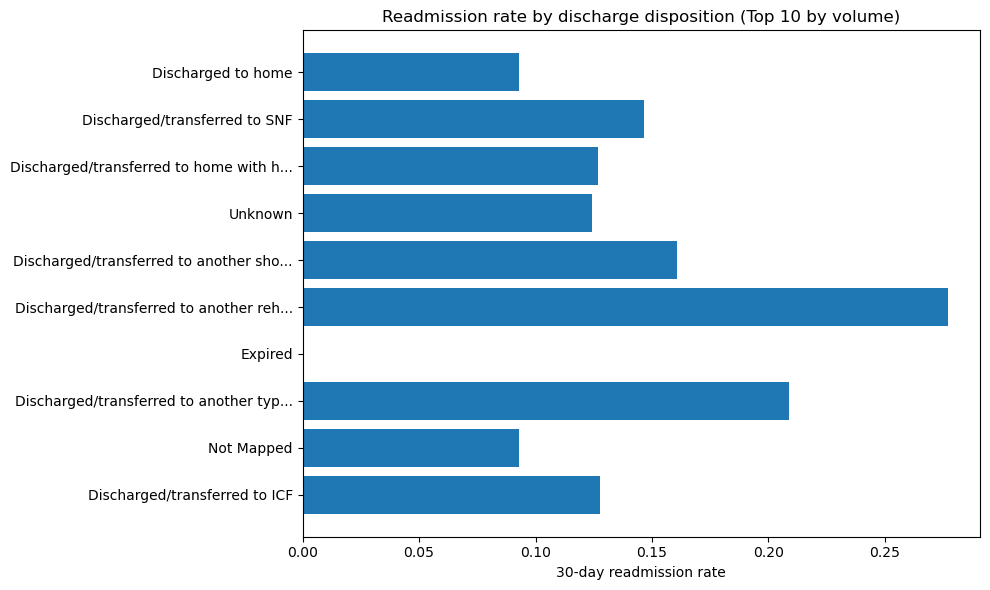


Rates (Top 10):
 discharge_disposition
Discharged to home                                                                   0.093004
Discharged/transferred to SNF                                                        0.146625
Discharged/transferred to home with home health service                              0.126957
Unknown                                                                              0.124357
Discharged/transferred to another short term hospital                                0.160714
Discharged/transferred to another rehab fac including rehab units of a hospital .    0.276969
Expired                                                                              0.000000
Discharged/transferred to another type of inpatient care institution                 0.208615
Not Mapped                                                                           0.093023
Discharged/transferred to ICF                                                        0.127607
Name: readmit_30, dt

In [79]:
dis_count = df["discharge_disposition"].value_counts()
top10 = dis_count.head(10).index

dis_rate = (
    df[df["discharge_disposition"].isin(top10)]
    .groupby("discharge_disposition")["readmit_30"].mean()
    .reindex(top10)
)

# Shorten labels for readability
def shorten(s, n=40):
    s = str(s)
    return s if len(s) <= n else s[:n-3] + "..."

labels = [shorten(x, 40) for x in dis_rate.index]

plt.figure(figsize=(10,6))
plt.barh(labels, dis_rate.values)
plt.xlabel("30-day readmission rate")
plt.title("Readmission rate by discharge disposition (Top 10 by volume)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nRates (Top 10):\n", dis_rate)


Home discharge has the lowest rate among common dispositions: 9.30% (baseline).

Post-acute / facility discharges are higher risk, e.g.

SNF: 14.66%

Short-term hospital transfer: 16.07%

Inpatient care institution: 20.86%

Rehab facility is extremely high (27.70%), but it’s usually lower volume and represents complex patients → high intervention priority.

# Readmission by Admission Rate

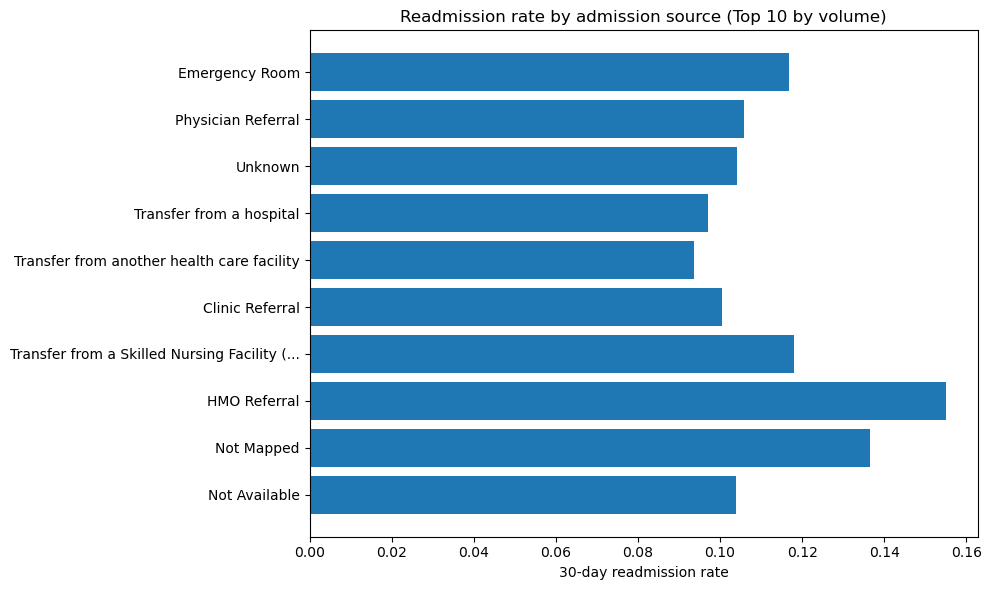

Counts (Top 10):
 admission_source
Emergency Room                                    57494
Physician Referral                                29565
Unknown                                            6781
Transfer from a hospital                           3187
Transfer from another health care facility         2264
Clinic Referral                                    1104
Transfer from a Skilled Nursing Facility (SNF)      855
HMO Referral                                        187
Not Mapped                                          161
Not Available                                       125
Name: count, dtype: int64

Rates (Top 10):
 admission_source
Emergency Room                                    0.116882
Physician Referral                                0.105868
Unknown                                           0.104114
Transfer from a hospital                          0.096956
Transfer from another health care facility        0.093640
Clinic Referral                                  

In [83]:
src_count = df["admission_source"].value_counts()
top10 = src_count.head(10).index

src_rate = (
    df[df["admission_source"].isin(top10)]
    .groupby("admission_source")["readmit_30"].mean()
    .reindex(top10)
)

def shorten(s, n=40):
    s = str(s)
    return s if len(s) <= n else s[:n-3] + "..."

labels = [shorten(x, 45) for x in src_rate.index]

plt.figure(figsize=(10,6))
plt.barh(labels, src_rate.values)
plt.xlabel("30-day readmission rate")
plt.title("Readmission rate by admission source (Top 10 by volume)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Counts (Top 10):\n", src_count.head(10))
print("\nRates (Top 10):\n", src_rate)


Admission source shows meaningful variation in readmission risk. ER admissions have higher risk than physician referrals, consistent with higher acuity. Some small-volume categories (e.g., HMO Referral, Not Mapped) show higher rates but are less reliable due to low sample size.”

# Medication Count Buckets

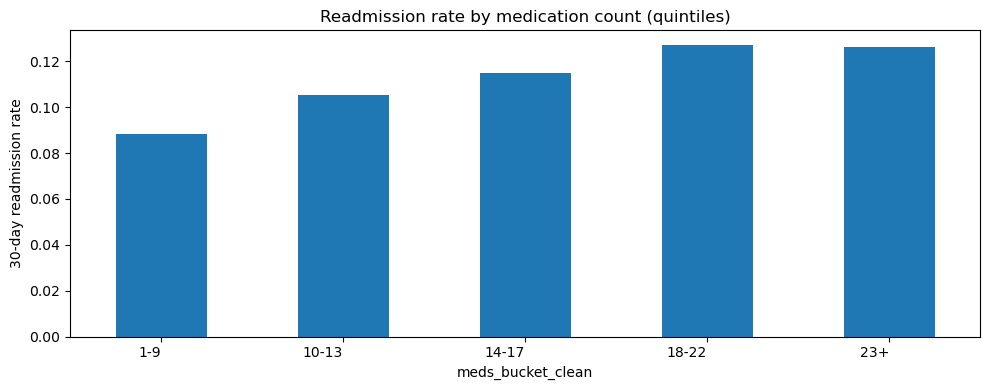

Counts:
 meds_bucket_clean
1-9      20515
10-13    23231
14-17    21848
18-22    18390
23+      17782
Name: count, dtype: int64

Rates:
 meds_bucket_clean
1-9      0.088277
10-13    0.105463
14-17    0.114930
18-22    0.127134
23+      0.126364
Name: readmit_30, dtype: float64


In [89]:

df["num_medications"] = pd.to_numeric(df["num_medications"], errors="coerce")
df["meds_bucket_clean"] = pd.cut(
    df["num_medications"],
    bins=[0, 9, 13, 17, 22, 100],
    labels=["1-9", "10-13", "14-17", "18-22", "23+"])

med_count = df["meds_bucket_clean"].value_counts().sort_index()
med_rate = df.groupby("meds_bucket_clean")["readmit_30"].mean().sort_index()

plt.figure(figsize=(10,4))
med_rate.plot(kind="bar")
plt.ylabel("30-day readmission rate")
plt.title("Readmission rate by medication count (quintiles)")
plt.xticks(rotation=0, ha="right")
plt.tight_layout()
plt.show()

print("Counts:\n", med_count)
print("\nRates:\n", med_rate)


“Higher medication count (proxy for clinical complexity) is associated with higher 30-day readmission risk; risk rises steadily from low-med to high-med groups.”

# Readmission rate by prior Utilization
### It measures, how prior visits (inpatient + ER + outpatient) relate to 30-day readmission.

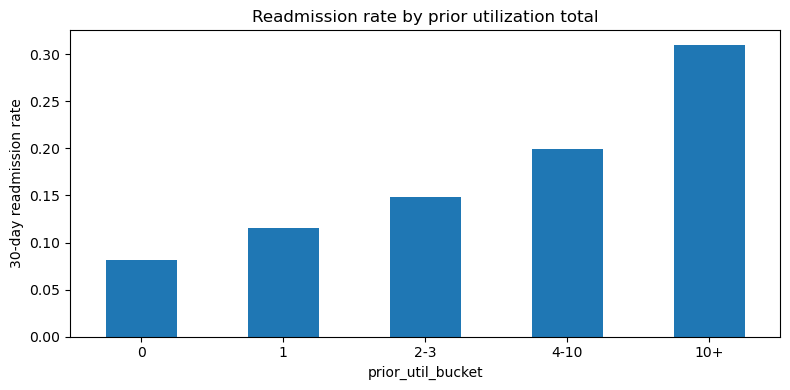

Counts:
 prior_util_bucket
0       55828
1       19941
2-3     15966
4-10     9041
10+       990
Name: count, dtype: int64

Rates:
 prior_util_bucket
0       0.081751
1       0.115641
2-3     0.148628
4-10    0.199867
10+     0.310101
Name: readmit_30, dtype: float64


In [90]:
# ensure numeric
for c in ["number_inpatient", "number_emergency", "number_outpatient"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df["prior_util_total"] = (
    df["number_inpatient"].fillna(0) +
    df["number_emergency"].fillna(0) +
    df["number_outpatient"].fillna(0)
)

df["prior_util_bucket"] = pd.cut(
    df["prior_util_total"],
    bins=[-1, 0, 1, 3, 10, 100],
    labels=["0", "1", "2-3", "4-10", "10+"]
)

util_count = df["prior_util_bucket"].value_counts().reindex(["0","1","2-3","4-10","10+"])
util_rate = df.groupby("prior_util_bucket")["readmit_30"].mean().reindex(["0","1","2-3","4-10","10+"])

plt.figure(figsize=(8,4))
util_rate.plot(kind="bar")
plt.ylabel("30-day readmission rate")
plt.title("Readmission rate by prior utilization total")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print("Counts:\n", util_count)
print("\nRates:\n", util_rate)


Readmission risk rises sharply with prior utilization:

0 visits: 8.18%

1 visit: 11.56%

2–3 visits: 14.86%

4–10 visits: 19.99%

10+ visits: 31.01% (high risk, low volume)

Prior utilization is the strongest observed driver in EDA: patients with 10+ prior visits have ~31% 30-day readmission risk vs ~8% for patients with no prior visits, supporting targeted follow-up and care coordination for frequent utilizers.

# HeatMap ( Age & LOS bucket)

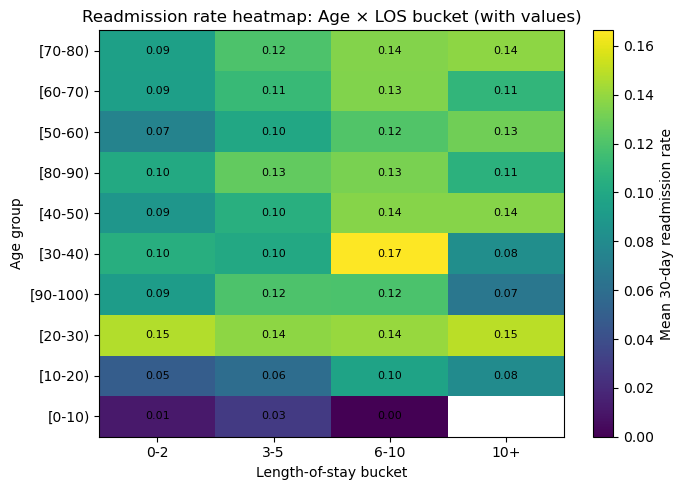

In [97]:
vals = pivot.values

plt.figure(figsize=(7,5))
plt.imshow(vals, aspect="auto")
plt.colorbar(label="Mean 30-day readmission rate")
plt.yticks(range(len(pivot.index)), pivot.index)
plt.xticks(range(len(pivot.columns)), pivot.columns)

# add text labels in each cell
for i in range(vals.shape[0]):
    for j in range(vals.shape[1]):
        if np.isfinite(vals[i, j]):
            plt.text(j, i, f"{vals[i,j]:.2f}", ha="center", va="center", fontsize=8)

plt.xlabel("Length-of-stay bucket")
plt.ylabel("Age group")
plt.title("Readmission rate heatmap: Age × LOS bucket (with values)")
plt.tight_layout()
plt.show()
